In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Part 1 : Get the data and Preprocess it 

In [25]:
# 1. Load the data from the .csv file, into a pandas dataframe (pandas makes loading csv files easy)
pd_data = pd.read_csv('./mnist_data/train.csv')

In [26]:
pd_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# a - convert the pandas dataframe to a numpy dataframe
np_data = np.array(pd_data)


# b - get the total number of rows and columns, and shuffle the dataset
rows, cols = np_data.shape
np.random.shuffle(np_data)


# c - now we only want to work with 1000 test and 41,000 training examples
test_data = np_data[0:1000].T # this get the first 1000 rows, and all their colums and transposes it 
    #  -- the end result is a  matric of (785-rows x 1000-cols), 
    #  --- where the rows = pixels + class, and cols = images (i.e. each column is one image)
    
    
# d - next we seperate the target values from the pixels 
y_test = test_data[0]
x_test = test_data[1: ]
x_test = x_test / 255.0 

''' WARNING !!!!! If you dont normalize, training will fail because of nan values -- 
        i.e when you update the values during backpropigation, since the values are large this
            causes some values to be so large they become nan's
'''

# e - and we do the same for the training data
train_data = np_data[1000:].T
y_train = train_data[0]
x_train = train_data[1:]
x_train = x_train / 255.0


In [28]:
# f - get the shapes of the test and train data
print(f"1. Train Data shape : {x_train.shape}")
print(f"2. Test Data shape : {x_test.shape}")

1. Train Data shape : (784, 41000)
2. Test Data shape : (784, 1000)


In [29]:
# g - we need to one hot encode the Y / Target values
def one_hot_encode(y):
    ''' Notes: 
        1 - this creates a one-hot colum vector for each value in the column vector, creating
            a matrix where each column is a one hot encoding of some number(digit) the picture is representing
            
        2 - this is a fast method of computing one hot encoding by using :
              a - np.arange - creates an array from 0 to the y.size(number of examples)
              b - [np.arange(y.size), y] - tells us the row we want to acess (np.arrange), 
                   and its correspoding column - which we want to set as 1 since its the proper class
    '''
    one_hot_y = np.zeros( (y.size, y.max()+1) ) # y.size = m (number of examples)
                                                # y.max() - is 9 because we assume 9 is the highest number
    
    one_hot_y[np.arange(y.size), y] = 1 
    one_hot_y = one_hot_y.T 
    return one_hot_y # we want each col to be an example rather than each row



In [30]:
# side note == see the difference between the sum() - sums the cols -  vs np.sum() function - which sums all the values in the np.array
a = np.array(( [1,2],
               [3,43]  ))
print(a/ sum(a))
print(a/ np.sum(a))

[[0.25       0.04444444]
 [0.75       0.95555556]]
[[0.02040816 0.04081633]
 [0.06122449 0.87755102]]


## Part 2 - create the neural network

In [31]:

""" Step 1 - Initalize all the parameters """
def initalize_params():
    # layer 1
    W_1 = np.random.rand(10,784) - 0.5 
    b_1 = np.random.rand(10,1) - 0.5 
    
    # layer 2
    W_2 = np.random.rand(10,10) - 0.5 
    b_2 = np.random.rand(10,1) - 0.5 
    
    '''  Notes :
            use rand - (dist. between 0 and 1) not randn - (dist between -0.5 and 0.5) 
            and we subtract 0.5 from them because we want the values to be between -0.5 and 0.5
             qq -- why??
    '''
    return W_1, b_1, W_2, b_2



""" Step 2 - Forward propagation """
def ReLU(Z):
    return np.maximum(Z, 0) # this is element wise application of ReLU
    
def SoftMax(Z):
    A = np.exp(Z)/sum(np.exp(Z)) 
    return A
    # np.exp - is done element-wise
    # sum(np.array(..)) - keeps the same # of cols and colapes the rows --  which is what we want
    # use sum not np.sum in order that the sum will be taken over a single column, not the whole matrix
    
def forward_propigation(W_1, b_1, W_2, b_2, X):
    
    # 1 - Input -> First Layer of Nodes
    Z_1 = W_1.dot(X) + b_1
    A_1 = ReLU(Z_1)
    
    # 2 - First Layer of Nodes -> Second Layer of Nodes    
    Z_2 = W_2.dot(A_1) + b_2
    A_2 = SoftMax(Z_2)
    
    return Z_1, A_1, Z_2 ,A_2


""" Step 3 - Backwards propagation """
def derivative_ReLU(Z):
    # for x > 0 its one, otherwise its zero - 
    #  - the z>0 is done element wise and true=1 and false=0, so this is a fast method of calcualting the derivative or ReLU
    return Z > 0

def backward_propigation(Z_1, A_1, Z_2 ,A_2, W_2, X, Y):
    one_hot_of_y = one_hot_encode(Y)
    m = Y.size

    dZ_2 = A_2 - one_hot_of_y

    dW_2 = ( 1/m ) * dZ_2.dot(A_1.T)
    
    db_2 = ( 1/m ) * np.sum(dZ_2)
    
    dZ_1 = W_2.T.dot(dZ_2) * derivative_ReLU(Z_1)
    
    dW_1 = ( 1/m ) * dZ_1.dot(X.T)
    
    db_1 = ( 1/m ) * np.sum(dZ_1)
    
    return dW_1, db_1, dW_2, db_2


""" Step 4 - Update the Parameters """
def update_params(W_1, b_1, W_2, b_2, dW_1, db_1, dW_2, db_2, alpha):
    W_1 = W_1 - alpha * dW_1
    b_1 = b_1 - alpha * db_1
    W_2 = W_2 - alpha * dW_2
    b_2 = b_2 - alpha * db_2
    
    return W_1, b_1, W_2, b_2
    
    

In [32]:
""" The functions to compute  (1) predictions, (2) accuracy and (3) loss """
def get_predictions(A_2):
    return np.argmax(A_2, axis=0) # axis=0 - for the max value in the columns
    # since the value with max probability will be the class that we predict
    
def get_accuracy(predictions, ground_truth):
    #print(predictions, ground_truth)
    return np.sum(predictions==ground_truth) / ground_truth.size

def get_loss(predicted, ground_truth):
    onehot_y = one_hot_encode(ground_truth)
    return abs(np.sum(onehot_y-predicted))
    

In [33]:
def gradiant_decent(X, Y, num_iterations, alpha):
    # step 1 - initalize our parameters
    W_1, b_1, W_2, b_2 = initalize_params()
    loss_history = []
    accuracy_history = []
    
    # step 2 - run gradiant decent on the our neural network for num_itterations
    for i in range(num_iterations):
        
        # a - forward propigation
        Z_1, A_1, Z_2 ,A_2 = forward_propigation(W_1, b_1, W_2, b_2, X)
        
        # b - backward propigation 
        dW_1, db_1, dW_2, db_2 = backward_propigation(Z_1, A_1, Z_2 ,A_2, W_2, X, Y)
        
        
        # c - update parameters
        W_1, b_1, W_2, b_2 = update_params(W_1, b_1, W_2, b_2, dW_1, db_1, dW_2, db_2, alpha)
        
        
        # d - print out the accuracy - every 50 itterations
        if i%10 == 0:
            print(f"Iteration  #{i}")
            print(f"-- Accuracy score : {get_accuracy(get_predictions(A_2), Y)}")

        # e - calculate the loss and accuracy of the model for the current itteration
        loss_history.append(get_loss(A_2, Y)) 
        accuracy_history.append(get_accuracy(get_predictions(A_2), Y))
        
    return W_1, b_1, W_2, b_2, loss_history, accuracy_history
    

## Part 3 - Train the Neural Network

In [34]:
W_1, b_1, W_2, b_2, loss_history, ac_history = gradiant_decent(x_train, y_train, 750, 0.1)

Iteration  #0
-- Accuracy score : 0.09195121951219512
Iteration  #10
-- Accuracy score : 0.20882926829268292
Iteration  #20
-- Accuracy score : 0.29892682926829267
Iteration  #30
-- Accuracy score : 0.37573170731707317
Iteration  #40
-- Accuracy score : 0.4427317073170732
Iteration  #50
-- Accuracy score : 0.492390243902439
Iteration  #60
-- Accuracy score : 0.5394634146341464
Iteration  #70
-- Accuracy score : 0.5805365853658536
Iteration  #80
-- Accuracy score : 0.6150731707317073
Iteration  #90
-- Accuracy score : 0.643
Iteration  #100
-- Accuracy score : 0.666609756097561
Iteration  #110
-- Accuracy score : 0.6875853658536585
Iteration  #120
-- Accuracy score : 0.7044634146341463
Iteration  #130
-- Accuracy score : 0.7180243902439024
Iteration  #140
-- Accuracy score : 0.7309268292682927
Iteration  #150
-- Accuracy score : 0.7411219512195122
Iteration  #160
-- Accuracy score : 0.7508048780487805
Iteration  #170
-- Accuracy score : 0.7599024390243903
Iteration  #180
-- Accuracy scor

## Part 4 - Plot the Loss and Accuracy over time

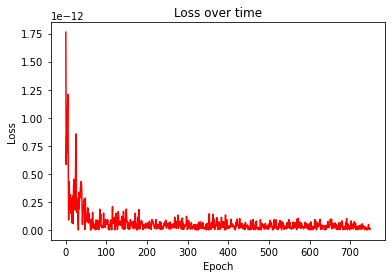

In [36]:
# PLOT 1 - Plot the Loss 

# a - setup the plot
fig, ax = plt.subplots()

# b - plot loss 
ax.plot(loss_history, 'r')

# c - labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss over time')

# d - display 
plt.show()

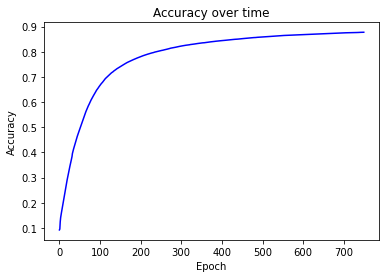

In [37]:
# PLOT 2 - Plot the Accuracy over time

# a - setup the plot
fig, ax = plt.subplots()

# b - plot accuracy
ax.plot(ac_history,  'b')

# c - labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy over time')

# d - display 
plt.show()

## Part 5 - Test performance on some examples, overall

In [38]:
def make_predictions(X, W_1, b_1, W_2, b_2):
    _, _, _, A_2 = forward_propigation(W_1, b_1, W_2, b_2, X)
    predictions = get_predictions(A_2)
    return predictions

def test_prediction(index, W_1, b_1, W_2, b_2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W_1, b_1, W_2, b_2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


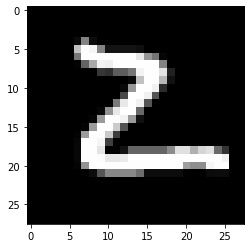

Prediction:  [2]
Label:  2


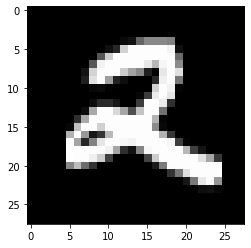

Prediction:  [2]
Label:  3


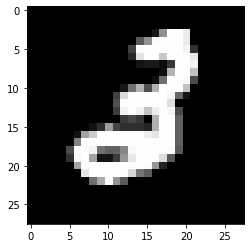

Prediction:  [4]
Label:  4


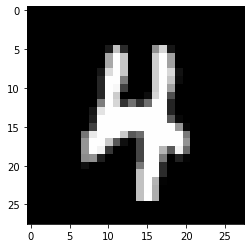

In [39]:
test_prediction(0, W_1, b_1, W_2, b_2)
test_prediction(1, W_1, b_1, W_2, b_2)
test_prediction(2, W_1, b_1, W_2, b_2)
test_prediction(3, W_1, b_1, W_2, b_2)

In [40]:
# Accuracy on Test Dataset
test_predictions = make_predictions(x_test, W_1, b_1, W_2, b_2)
get_accuracy(test_predictions, y_test)

0.858